In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the main directory containing the dataset
base_path = 'Lung Disease Dataset'

# Helper function to load images from a specific subdirectory
def load_images_from_folder(folder_path):
    images = []
    labels = []
    disease_types = os.listdir(folder_path)
    for disease in disease_types:
        disease_path = os.path.join(folder_path, disease)
        file_names = [f for f in os.listdir(disease_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        for filename in file_names:
            img = cv2.imread(os.path.join(disease_path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img)
                labels.append(disease)  # Label as the disease type
    return images, labels

# Function to preprocess images
def preprocess_images(images, size=(224, 224)):
    images_resized = [cv2.resize(img, size) for img in images]
    images_normalized = np.array(images_resized) / 255.0  # Normalize pixel values
    return images_normalized

# Function to process training images
def process_train_images():
    train_path = os.path.join(base_path, 'train')
    train_images, train_labels = load_images_from_folder(train_path)
    train_images = preprocess_images(train_images)
    return train_images, train_labels

# Function to process testing images
def process_test_images():
    test_path = os.path.join(base_path, 'test')
    test_images, test_labels = load_images_from_folder(test_path)
    test_images = preprocess_images(test_images)
    return test_images, test_labels

# Function to process validation images
def process_val_images():
    val_path = os.path.join(base_path, 'val')
    val_images, val_labels = load_images_from_folder(val_path)
    val_images = preprocess_images(val_images)
    return val_images, val_labels


In [2]:
# Example usage
train_images, train_labels = process_train_images()

KeyboardInterrupt: 

In [3]:
# Example usage
test_images, test_labels = process_test_images()

In [4]:
# Example usage
val_images, val_labels = process_val_images()

In [5]:
# # Load and preprocess images
# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# trains_encoded = encoder.fit_transform(train_labels)
# trains_one_hot = to_categorical(trains_encoded)

In [9]:
# tests_encoded = encoder.fit_transform(test_labels)
# tests_one_hot = to_categorical(tests_encoded)

In [8]:
# vals_encoded = encoder.fit_transform(val_labels)
# vals_one_hot = to_categorical(vals_encoded)

In [10]:
# print(trains_one_hot.shape)
# print(train_images.shape)
# print(tests_one_hot.shape)
# print(test_images.shape)
# print(vals_one_hot.shape)
# print(val_images.shape)

(6054, 5)
(6054, 224, 224, 3)
(2025, 5)
(2025, 224, 224, 3)
(2016, 5)
(2016, 224, 224, 3)


In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(images):
    # Convert images to the format InceptionV3 expects
    images = preprocess_input(images)
    # Use InceptionV3 to extract features
    features = model.predict(images, batch_size=32)
    # Flatten the features to fit into XGBoost
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

In [13]:
import xgboost as xgb

def train_xgboost(features, labels):
    # Create a DMatrix for XGBoost
    dtrain = xgb.DMatrix(features, label=labels)
    # Set up parameters for XGBoost
    params = {
        'objective': 'multi:softprob',
        'num_class': 5,  # adjust based on the number of classes in your dataset
        'learning_rate': 0.1,
        'max_depth': 3,
        'alpha': 10,
        'n_estimators': 100
    }
    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=10)
    return model


In [15]:
# Function to convert labels from names to integers
def labels_to_integers(labels):
    label_dict = {name: i for i, name in enumerate(np.unique(labels))}
    return [label_dict[label] for label in labels]

# Process images and train the model
# train_images, train_labels = process_train_images()
train_features = extract_features(train_images)
train_labels_encoded = labels_to_integers(train_labels)
xgb_model = train_xgboost(train_features, train_labels_encoded)

# Similarly, extract features and test with the validation set
# val_images, val_labels = process_val_images()
val_features = extract_features(val_images)
val_labels_encoded = labels_to_integers(val_labels)
dval = xgb.DMatrix(val_features)
predictions = xgb_model.predict(dval)


190/190 ━━━━━━━━━━━━━━━━━━━━ 70s 364ms/step


c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:20:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 996ms/step


In [19]:
predicted_labels = np.argmax(predictions, axis=1)

In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(val_labels_encoded, predicted_labels)

In [21]:
print(accuracy)

0.2996031746031746


In [22]:
import os
import cv2
import numpy as np
import xgboost as xgb
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

# Load the InceptionV3 model pre-trained on ImageNet data, without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to load images and labels from a specific subdirectory
def load_images_from_folder(folder_path):
    images = []
    labels = []
    disease_types = os.listdir(folder_path)
    for disease in disease_types:
        disease_path = os.path.join(folder_path, disease)
        file_names = [f for f in os.listdir(disease_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        for filename in file_names:
            img = cv2.imread(os.path.join(disease_path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img)
                labels.append(disease)  # Label as the disease type
    return images, labels

# Function to preprocess images using InceptionV3 standards
def preprocess_images(images):
    images = np.array([cv2.resize(img, (224, 224)) for img in images])  # Resize images
    images = preprocess_input(images)  # Use preprocess input from InceptionV3
    return images

# Function to extract features using InceptionV3
def extract_features(images):
    features = model.predict(images, batch_size=32)
    return features

# Function to encode labels as integers
def labels_to_integers(labels):
    unique_labels = np.unique(labels)
    label_dict = {label: idx for idx, label in enumerate(unique_labels)}
    return [label_dict[label] for label in labels], len(unique_labels)

# Function to train XGBoost model
def train_xgboost(features, labels):
    labels, num_classes = labels_to_integers(labels)
    dtrain = xgb.DMatrix(features, label=labels)
    params = {
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'learning_rate': 0.1,
        'max_depth': 3,
        'n_estimators': 100
    }
    model = xgb.train(params, dtrain, num_boost_round=10)
    return model

# Function to evaluate model accuracy
def evaluate_model(model, features, true_labels):
    dtest = xgb.DMatrix(features)
    predictions = model.predict(dtest)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

# Main workflow
base_path = 'Lung Disease Dataset'  # Adjust this to your dataset's path
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')

# Process training images
train_images, train_labels = load_images_from_folder(train_path)
train_images = preprocess_images(train_images)
train_features = extract_features(train_images)
train_labels_encoded, _ = labels_to_integers(train_labels)
xgb_model = train_xgboost(train_features, train_labels_encoded)

# Process validation images
val_images, val_labels = load_images_from_folder(val_path)
val_images = preprocess_images(val_images)
val_features = extract_features(val_images)
val_labels_encoded, _ = labels_to_integers(val_labels)

# Evaluate the model
model_accuracy = evaluate_model(xgb_model, val_features, val_labels_encoded)
print(f"Validation Accuracy: {model_accuracy:.2f}")


190/190 ━━━━━━━━━━━━━━━━━━━━ 72s 367ms/step


c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 358ms/step
Validation Accuracy: 0.70


In [11]:
import os
import cv2
import numpy as np
import xgboost as xgb
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score 

# Load the InceptionV3 model pre-trained on ImageNet data, without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to load images and labels from a specific subdirectory
def load_images_from_folder(folder_path):
    images = []
    labels = []
    disease_types = os.listdir(folder_path)
    for disease in disease_types:
        disease_path = os.path.join(folder_path, disease)
        file_names = [f for f in os.listdir(disease_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        for filename in file_names:
            img = cv2.imread(os.path.join(disease_path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img)
                labels.append(disease)  # Label as the disease type
    return images, labels

# Function to preprocess images using InceptionV3 standards
def preprocess_images(images):
    images = np.array([cv2.resize(img, (224, 224)) for img in images])  # Resize images
    images = preprocess_input(images)  # Use preprocess input from InceptionV3
    return images

# Function to extract features using InceptionV3
def extract_features(images):
    features = model.predict(images, batch_size=32)
    return features

# Function to encode labels as integers
def labels_to_integers(labels):
    unique_labels = np.unique(labels)
    label_dict = {label: idx for idx, label in enumerate(unique_labels)}
    return [label_dict[label] for label in labels], len(unique_labels)

# Function to train XGBoost model
def train_xgboost(features, labels):
    labels, num_classes = labels_to_integers(labels)
    dtrain = xgb.DMatrix(features, label=labels)
    params = {
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'learning_rate': 0.1,
        'max_depth': 3,
        'n_estimators': 100
    }
    model = xgb.train(params, dtrain, num_boost_round=10)
    return model

# Function to evaluate model accuracy
def evaluate_model(model, features, true_labels):
    dtest = xgb.DMatrix(features)
    predictions = model.predict(dtest)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

# Main workflow
base_path = 'Lung Disease Dataset'  # Adjust this to your dataset's path
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')

# Process training images
train_images, train_labels = load_images_from_folder(train_path)
train_images = preprocess_images(train_images)
train_features = extract_features(train_images)
train_labels_encoded, _ = labels_to_integers(train_labels)
xgb_model = train_xgboost(train_features, train_labels_encoded)

# Process validation images
val_images, val_labels = load_images_from_folder(val_path)
val_images = preprocess_images(val_images)
val_features = extract_features(val_images)
val_labels_encoded, _ = labels_to_integers(val_labels)

# Evaluate the model
model_accuracy = evaluate_model(xgb_model, val_features, val_labels_encoded)
print(f"Validation Accuracy: {model_accuracy:.2f}")



190/190 ━━━━━━━━━━━━━━━━━━━━ 114s 584ms/step


c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 694ms/step
Validation Accuracy: 0.79


63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 579ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

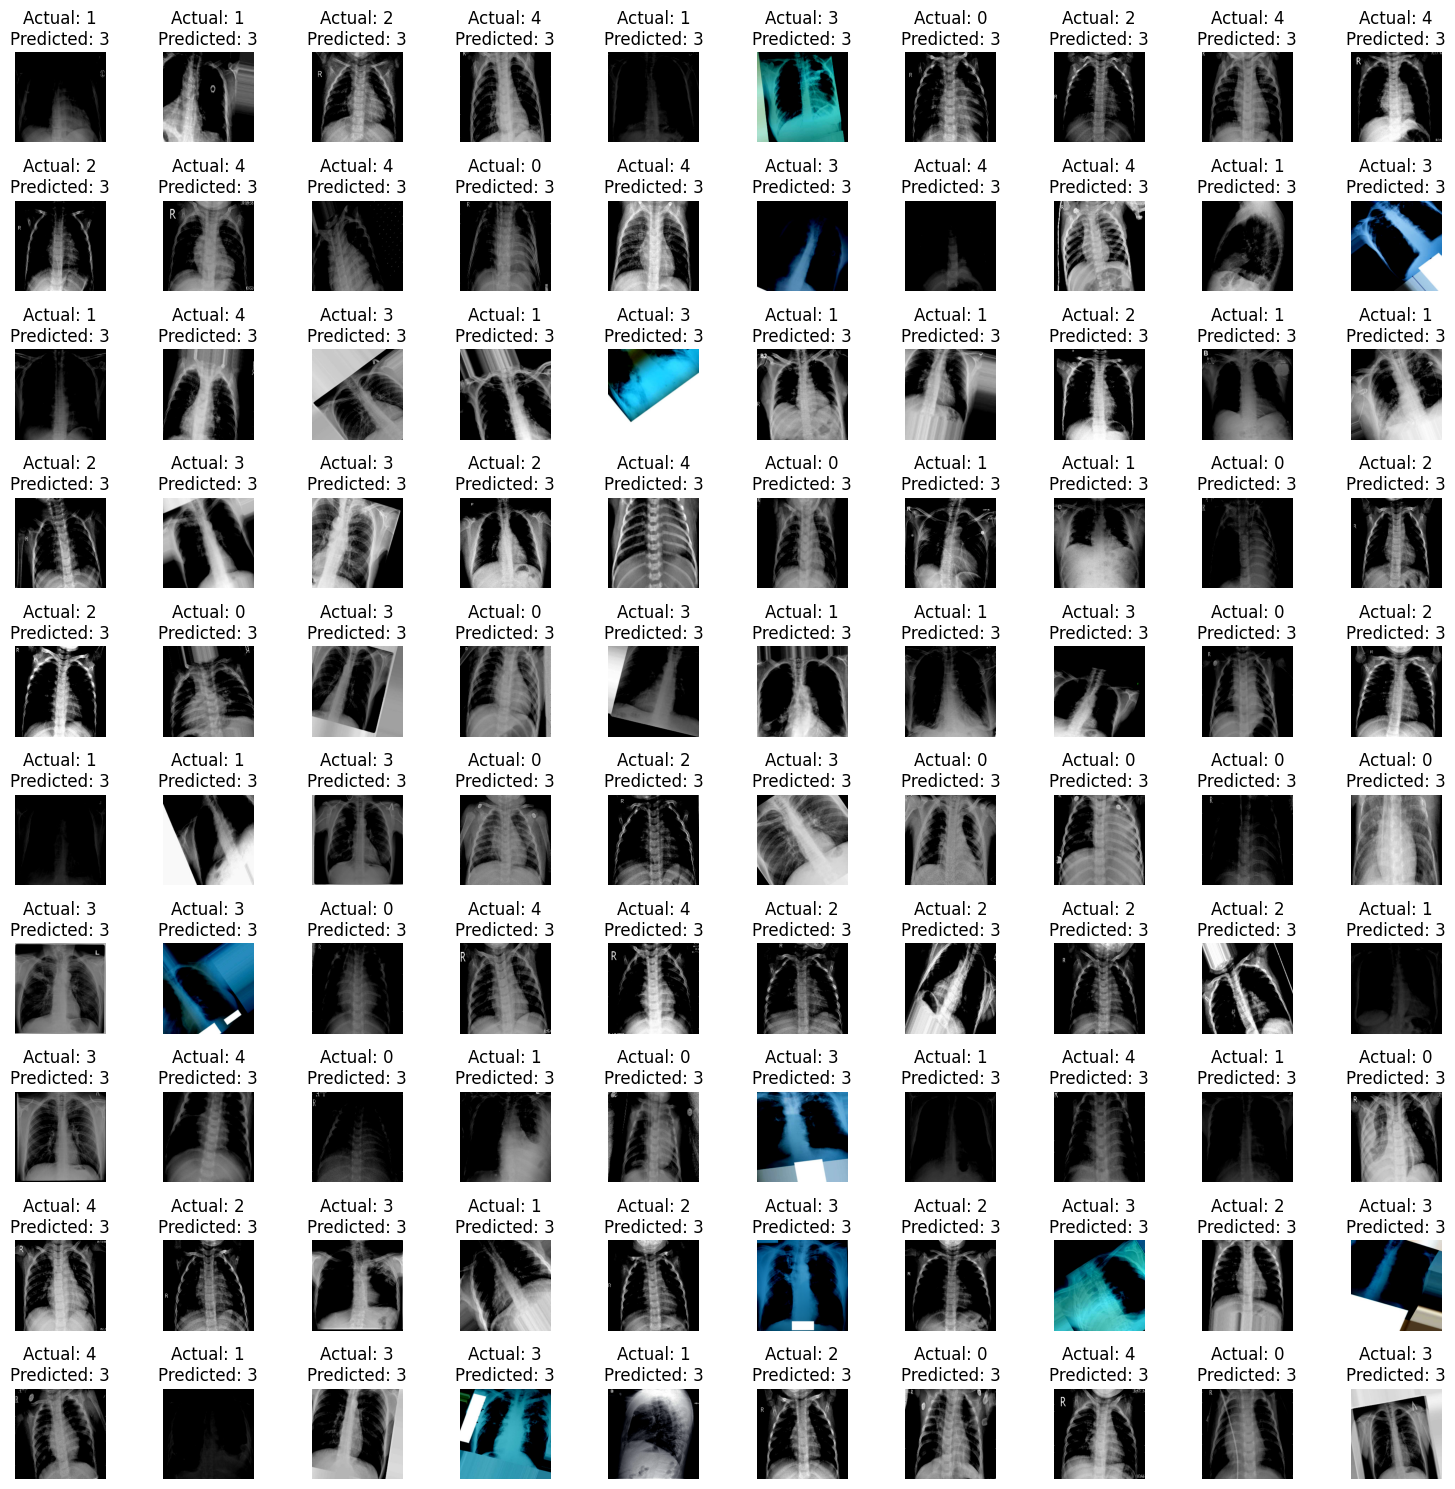

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

def plot_predictions(model, X_test, y_test, images, r=5, c=5):
    fig, axes = plt.subplots(r, c, figsize=(15, 15))
    axes = axes.ravel()

    # Prepare the batch of data for prediction
    features = extract_features(X_test)  # Extract features for X_test which are already preprocessed
    dtest = xgb.DMatrix(features)  # Prepare DMatrix for XGBoost
    probabilities = model.predict(dtest)  # Get class probabilities
    predictions = np.argmax(probabilities, axis=1)  # Convert probabilities to class predictions

    # Plot random images with their actual and predicted labels
    indices = np.random.choice(list(range(len(images))), size=r*c, replace=False)
    for i, ax in enumerate(axes):
        ax.imshow(images[indices[i]])  # Display the image
        actual_label = y_test[indices[i]]  # y_test should be integer labels, not one-hot
        predicted_label = predictions[indices[i]]
        ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# Ensure `val_images` are preprocessed appropriately and `val_labels_encoded` are integer labels
val_images_processed = preprocess_images(val_images)  # This should be done before calling plot_predictions if not already
plot_predictions(xgb_model, val_images_processed, val_labels_encoded, val_images, r=10, c=10)


In [2]:
import os
import cv2
import numpy as np
import xgboost as xgb
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score 

# Load the InceptionV3 model pre-trained on ImageNet data, without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to load images and labels from a specific subdirectory
def load_images_from_folder(folder_path):
    images = []
    labels = []
    disease_types = os.listdir(folder_path)
    for disease in disease_types:
        disease_path = os.path.join(folder_path, disease)
        file_names = [f for f in os.listdir(disease_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        for filename in file_names:
            img = cv2.imread(os.path.join(disease_path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img)
                labels.append(disease)  # Label as the disease type
    return images, labels

# Function to preprocess images using InceptionV3 standards
def preprocess_images(images):
    images = np.array([cv2.resize(img, (224, 224)) for img in images])  # Resize images
    images = preprocess_input(images)  # Use preprocess input from InceptionV3
    return images

# Function to extract features using InceptionV3
def extract_features(images):
    features = model.predict(images, batch_size=32)
    return features

# Function to encode labels as integers
def labels_to_integers(labels):
    unique_labels = np.unique(labels)
    label_dict = {label: idx for idx, label in enumerate(unique_labels)}
    return [label_dict[label] for label in labels], len(unique_labels)

# Function to train XGBoost model
def train_xgboost(features, labels):
    labels, num_classes = labels_to_integers(labels)
    dtrain = xgb.DMatrix(features, label=labels)
    params = {
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'learning_rate': 0.1,
        'max_depth': 3,
        'n_estimators': 100
    }
    model = xgb.train(params, dtrain, num_boost_round=10)
    return model

# Function to evaluate model accuracy
def evaluate_model(model, features, true_labels):
    dtest = xgb.DMatrix(features)
    predictions = model.predict(dtest)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

# Main workflow
base_path = 'Lung Disease Dataset'  # Adjust this to your dataset's path
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')

# Process training images
train_images, train_labels = load_images_from_folder(train_path)
train_images = preprocess_images(train_images)
train_features = extract_features(train_images)
train_labels_encoded, _ = labels_to_integers(train_labels)
xgb_model = train_xgboost(train_features, train_labels_encoded)

# Process validation images
val_images, val_labels = load_images_from_folder(val_path)
val_images = preprocess_images(val_images)
val_features = extract_features(val_images)
val_labels_encoded, _ = labels_to_integers(val_labels)

# Evaluate the model
model_accuracy = evaluate_model(xgb_model, val_features, val_labels_encoded)
print(f"Validation Accuracy: {model_accuracy:.2f}")



190/190 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step


c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step
Validation Accuracy: 0.70


63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 539ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

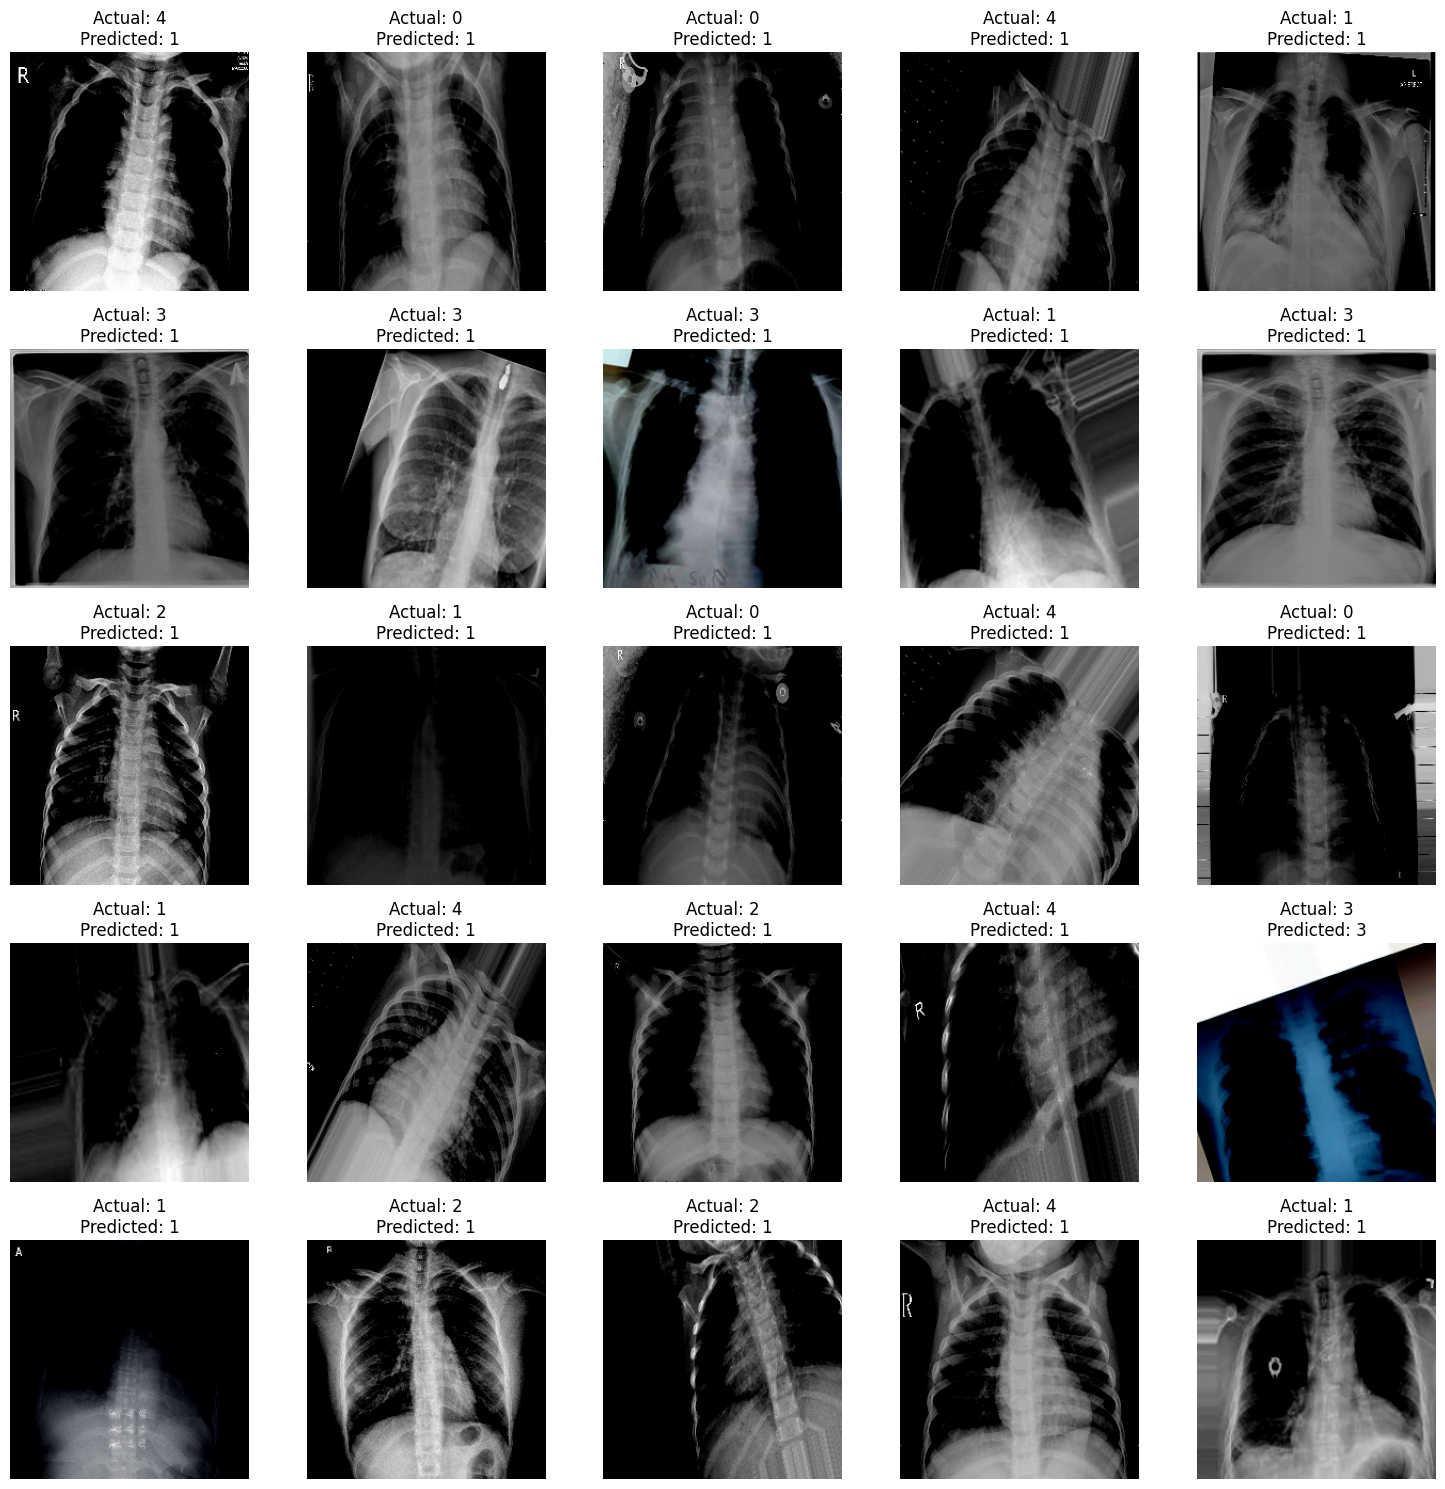

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

def plot_predictions(model, X_test, y_test, images, r=5, c=5):
    fig, axes = plt.subplots(r, c, figsize=(15, 15))
    axes = axes.ravel()

    # Prepare the batch of data for prediction
    features = extract_features(X_test)  # Extract features for X_test which are already preprocessed
    dtest = xgb.DMatrix(features)  # Prepare DMatrix for XGBoost
    probabilities = model.predict(dtest)  # Get class probabilities
    predictions = np.argmax(probabilities, axis=1)  # Convert probabilities to class predictions

    # Plot random images with their actual and predicted labels
    indices = np.random.choice(list(range(len(images))), size=r*c, replace=False)
    for i, ax in enumerate(axes):
        ax.imshow(images[indices[i]])  # Display the image
        actual_label = y_test[indices[i]]  # y_test should be integer labels, not one-hot
        predicted_label = predictions[indices[i]]
        ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# Ensure `val_images` are preprocessed appropriately and `val_labels_encoded` are integer labels
val_images_processed = preprocess_images(val_images)  # This should be done before calling plot_predictions if not already
plot_predictions(xgb_model, val_images_processed, val_labels_encoded, val_images, r=5, c=5)
